In [1]:
# Load the original T5 model (no adapters)
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_name = "/root/projects/O-LoRA/initial_model/t5-large"  # or "t5-large" for hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.eval()
print(f"Loaded T5: {model_name}")

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loaded T5: /root/projects/O-LoRA/initial_model/t5-large


In [2]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [3]:
# Load the LoRA adapter using the project's custom PEFT (handles r_sum for accumulated rank)
import sys
sys.path.insert(0, "/root/projects/O-LoRA/src")
from peft import PeftModel  # This imports from src/peft, not the pip package

adapter_path = "/root/projects/O-LoRA/logs_and_outputs/ella/long/order_5/outputs1/15-yahoo/adapter"
model = PeftModel.from_pretrained(model, adapter_path)
model.eval()
print(f"Loaded adapter from: {adapter_path}")

Loaded adapter from: /root/projects/O-LoRA/logs_and_outputs/ella/long/order_5/outputs1/15-yahoo/adapter


In [4]:
model

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 1024)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 1024)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=1024, out_features=1024, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1024, out_features=120, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=120, out_features=1024, bias=False)
                    )
                    (loranew_A): ModuleDict(
                      (default): Linear(in_

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Collect all lora_B @ lora_A products (W_past) from the model
w_past_values = []
layer_names = []

for name, module in model.named_modules():
    # Check if this module has lora_A and lora_B
    if hasattr(module, 'lora_A') and hasattr(module, 'lora_B'):
        for adapter_name in module.lora_A.keys():
            lora_A = module.lora_A[adapter_name].weight  # [r, d_in]
            lora_B = module.lora_B[adapter_name].weight  # [d_out, r]
            
            # Compute W_past = lora_B @ lora_A
            with torch.no_grad():
                W_past = torch.mm(lora_B, lora_A)  # [d_out, d_in]
                w_past_values.append(W_past.flatten().cpu().numpy())
                layer_names.append(name)

print(f"Found {len(w_past_values)} LoRA layers")
print(f"First few layers: {layer_names[:5]}")

Found 144 LoRA layers
First few layers: ['base_model.model.encoder.block.0.layer.0.SelfAttention.q', 'base_model.model.encoder.block.0.layer.0.SelfAttention.v', 'base_model.model.encoder.block.1.layer.0.SelfAttention.q', 'base_model.model.encoder.block.1.layer.0.SelfAttention.v', 'base_model.model.encoder.block.2.layer.0.SelfAttention.q']


/tmp/ipykernel_12066/220668372.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot([encoder_values, decoder_values], labels=['Encoder', 'Decoder'])


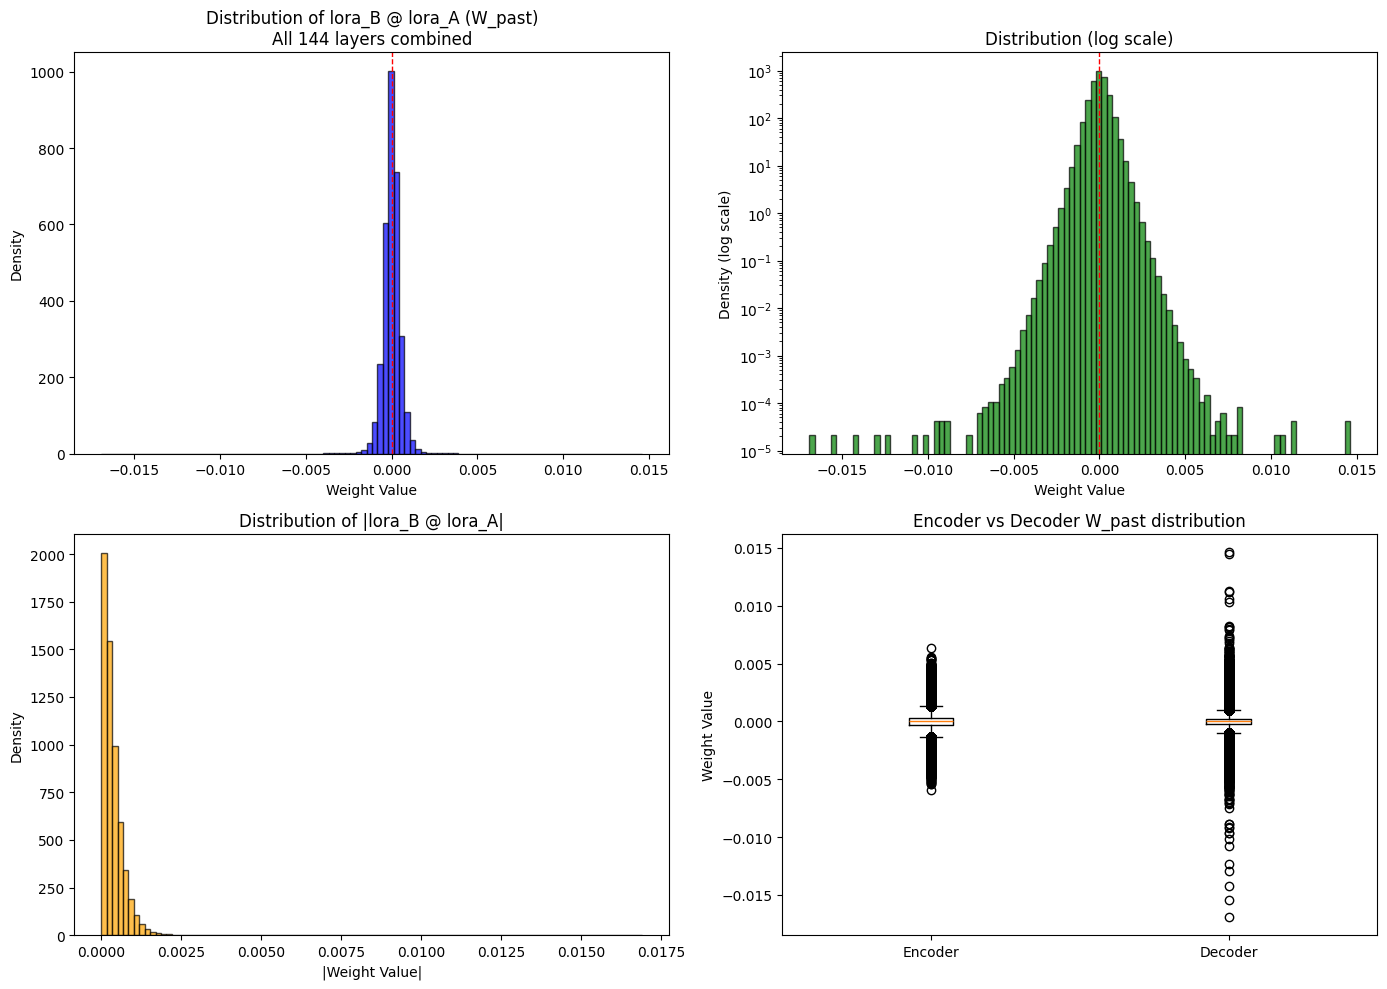


Statistics for W_past = lora_B @ lora_A:
  Total values: 150,994,944
  Mean: -0.000000
  Std: 0.000470
  Min: -0.016910
  Max: 0.014620
  Median: -0.000000
  % near zero (|x| < 0.001): 95.63%
  % near zero (|x| < 0.01): 100.00%


In [7]:
# Plot distribution of all W_past values combined
all_values = np.concatenate(w_past_values)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of all values
ax1 = axes[0, 0]
ax1.hist(all_values, bins=100, density=True, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Density')
ax1.set_title(f'Distribution of lora_B @ lora_A (W_past)\nAll {len(w_past_values)} layers combined')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=1)

# 2. Log-scale histogram
ax2 = axes[0, 1]
ax2.hist(all_values, bins=100, density=True, alpha=0.7, color='green', edgecolor='black')
ax2.set_xlabel('Weight Value')
ax2.set_ylabel('Density (log scale)')
ax2.set_title('Distribution (log scale)')
ax2.set_yscale('log')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=1)

# 3. Absolute values distribution
ax3 = axes[1, 0]
abs_values = np.abs(all_values)
ax3.hist(abs_values, bins=100, density=True, alpha=0.7, color='orange', edgecolor='black')
ax3.set_xlabel('|Weight Value|')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of |lora_B @ lora_A|')

# 4. Box plot per layer type (encoder vs decoder)
ax4 = axes[1, 1]
encoder_values = []
decoder_values = []
for name, values in zip(layer_names, w_past_values):
    if 'encoder' in name:
        encoder_values.extend(values)
    elif 'decoder' in name:
        decoder_values.extend(values)

ax4.boxplot([encoder_values, decoder_values], labels=['Encoder', 'Decoder'])
ax4.set_ylabel('Weight Value')
ax4.set_title('Encoder vs Decoder W_past distribution')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nStatistics for W_past = lora_B @ lora_A:")
print(f"  Total values: {len(all_values):,}")
print(f"  Mean: {np.mean(all_values):.6f}")
print(f"  Std: {np.std(all_values):.6f}")
print(f"  Min: {np.min(all_values):.6f}")
print(f"  Max: {np.max(all_values):.6f}")
print(f"  Median: {np.median(all_values):.6f}")
print(f"  % near zero (|x| < 0.001): {100 * np.mean(np.abs(all_values) < 0.001):.2f}%")
print(f"  % near zero (|x| < 0.01): {100 * np.mean(np.abs(all_values) < 0.01):.2f}%")

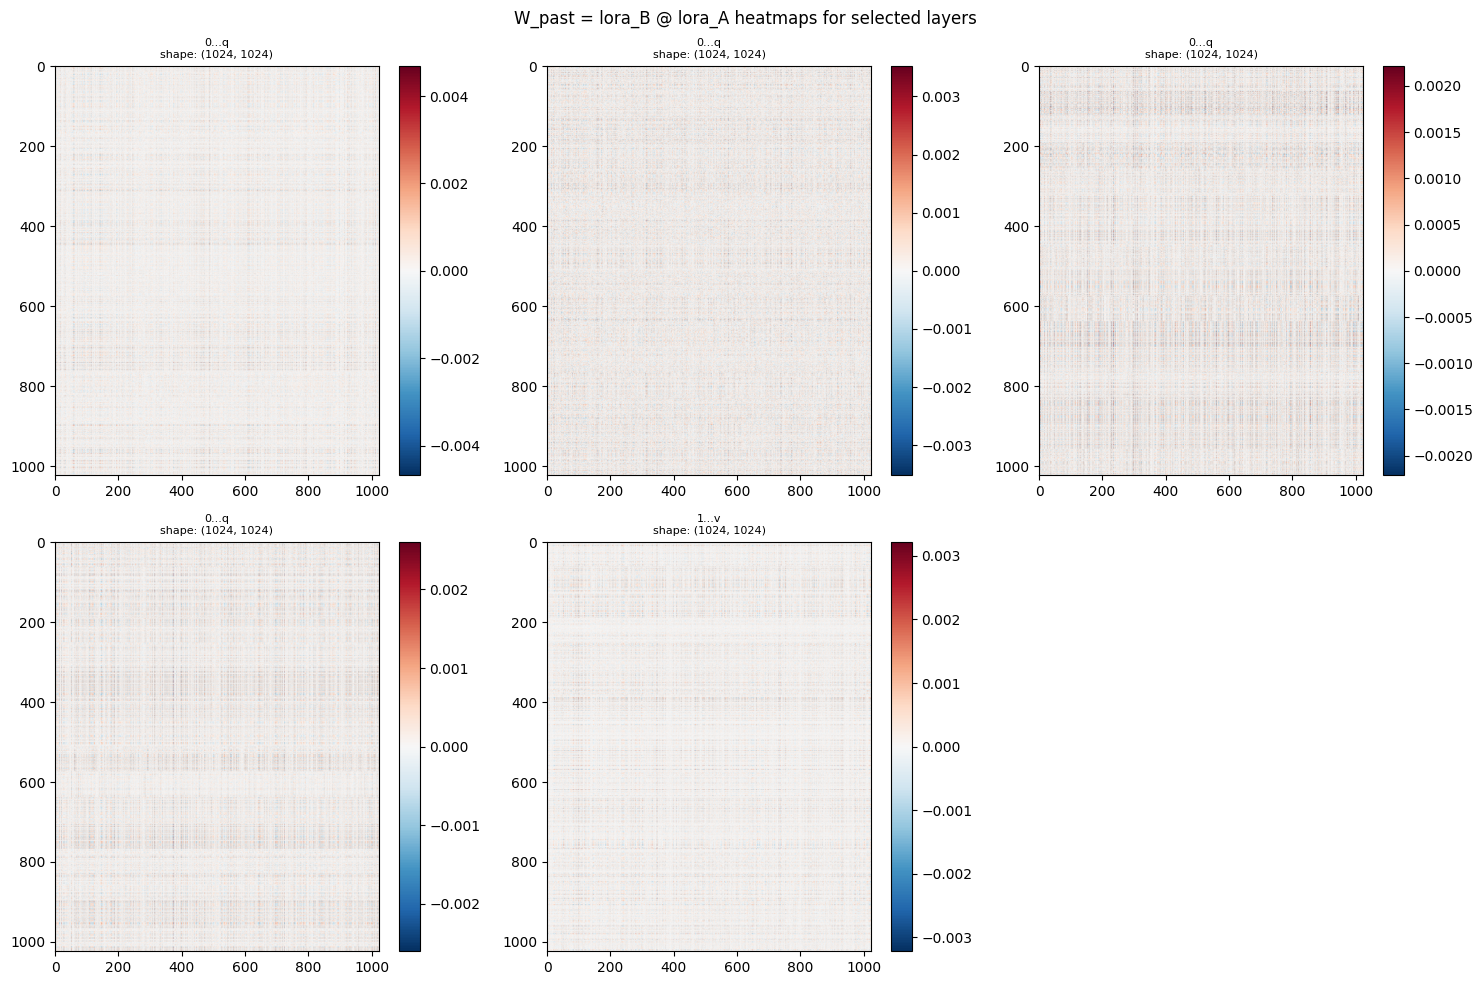

In [8]:
# Visualize W_past as heatmaps for a few layers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select a few representative layers
sample_indices = [0, len(layer_names)//4, len(layer_names)//2, 3*len(layer_names)//4, len(layer_names)-1]
sample_indices = sample_indices[:5]  # Take at most 5

for idx, (ax, layer_idx) in enumerate(zip(axes[:len(sample_indices)], sample_indices)):
    name = layer_names[layer_idx]
    
    # Recompute W_past for this layer to get the 2D matrix
    for n, module in model.named_modules():
        if n == name and hasattr(module, 'lora_A') and hasattr(module, 'lora_B'):
            for adapter_name in module.lora_A.keys():
                lora_A = module.lora_A[adapter_name].weight
                lora_B = module.lora_B[adapter_name].weight
                with torch.no_grad():
                    W_past = torch.mm(lora_B, lora_A).cpu().numpy()
                
                im = ax.imshow(W_past, aspect='auto', cmap='RdBu_r', 
                              vmin=-np.max(np.abs(W_past)), vmax=np.max(np.abs(W_past)))
                ax.set_title(f'{name.split(".")[-3]}...{name.split(".")[-1]}\nshape: {W_past.shape}', fontsize=8)
                plt.colorbar(im, ax=ax)
                break

# Hide unused axes
for ax in axes[len(sample_indices):]:
    ax.axis('off')

plt.suptitle('W_past = lora_B @ lora_A heatmaps for selected layers', fontsize=12)
plt.tight_layout()
plt.show()

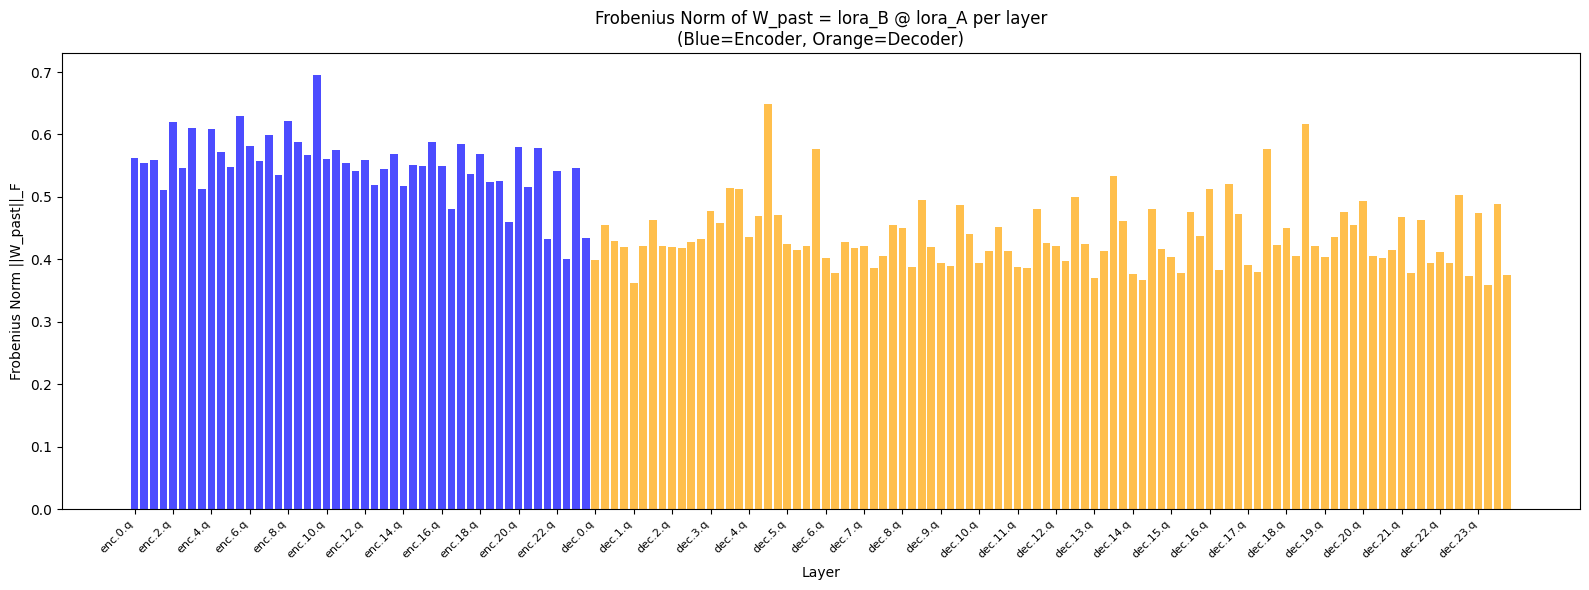


Frobenius Norm Statistics:
  Mean: 0.4753
  Std: 0.0755
  Min: 0.3582 (dec.23.v)
  Max: 0.6951 (enc.9.v)


In [9]:
# Compute Frobenius norm of W_past for each layer
frobenius_norms = []
layer_short_names = []

for name, module in model.named_modules():
    if hasattr(module, 'lora_A') and hasattr(module, 'lora_B'):
        for adapter_name in module.lora_A.keys():
            lora_A = module.lora_A[adapter_name].weight
            lora_B = module.lora_B[adapter_name].weight
            with torch.no_grad():
                W_past = torch.mm(lora_B, lora_A)
                frob_norm = torch.norm(W_past, p='fro').item()
                frobenius_norms.append(frob_norm)
                # Create short name: encoder/decoder + block number + q/v
                parts = name.split('.')
                short_name = f"{parts[2][:3]}.{parts[4]}.{parts[-1]}"  # e.g., "enc.0.q"
                layer_short_names.append(short_name)

# Plot Frobenius norms
fig, ax = plt.subplots(figsize=(16, 6))
x = range(len(frobenius_norms))
colors = ['blue' if 'enc' in n else 'orange' for n in layer_short_names]
ax.bar(x, frobenius_norms, color=colors, alpha=0.7)
ax.set_xlabel('Layer')
ax.set_ylabel('Frobenius Norm ||W_past||_F')
ax.set_title('Frobenius Norm of W_past = lora_B @ lora_A per layer\n(Blue=Encoder, Orange=Decoder)')
ax.set_xticks(x[::4])
ax.set_xticklabels(layer_short_names[::4], rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

print(f"\nFrobenius Norm Statistics:")
print(f"  Mean: {np.mean(frobenius_norms):.4f}")
print(f"  Std: {np.std(frobenius_norms):.4f}")
print(f"  Min: {np.min(frobenius_norms):.4f} ({layer_short_names[np.argmin(frobenius_norms)]})")
print(f"  Max: {np.max(frobenius_norms):.4f} ({layer_short_names[np.argmax(frobenius_norms)]})")